# Reconstructing the booking history of the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`.  A preliminary investigation of the dataset is done in `UHCW_EDA.ipynb`.

In this notebook we reconstruct the booking history of all appointments in all centers.

## Imports

In [1]:
import os
import pandas as pd
import datetime
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

Record time of beginning of script:

In [2]:
beg_script = datetime.datetime.now()

## Constants

In [3]:
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_london = pytz.timezone("Europe/London")  # test centers are in Coventry, UK

IMG_DIR = os.path.join(os.path.expanduser("~"), "Projects/UHCW/IMAGE_FILES")

## Helper functions

In [4]:
def cartesianProduct(left, right):
    """Returns Cartesian product of dataframe.
    From https://stackoverflow.com/a/53699013/9472676 with some arrangement:
    """
    # Rename columns if "key" already exists.
    if "key" in list(left.columns):
        key_x = "key_x"
    else:
        key_x = ""
    if "key" in list(right.columns):
        key_y = "key_x"
    else:
        key_y = ""
    new_key = hash("".join(list(left.columns) + list(right.columns)))
    left.rename(index=str, columns={"key": str(new_key)}, inplace=True)
    right.rename(index=str, columns={"key": str(new_key)}, inplace=True)
    # Calculate Cartesian product
    df_cartesian = left.assign(key=1).merge(
        right.assign(key=1), on='key'
    ).drop('key', 1)
    # Rename columns back to "key" if they had been changed
    left.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    right.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    if (key_x != "") and (key_y != ""):
        df_cartesian.rename(index=str, columns={str(new_key)+"_x": "key_x"}, inplace=True)
        df_cartesian.rename(index=str, columns={str(new_key)+"_y": "key_y"}, inplace=True)
    else:
        df_cartesian.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    return df_cartesian


In [5]:
def get_timegrid(df):
    """Generate the timegrid from the full dataset."""
    grabs = df.loc[:, ['grab']].drop_duplicates().reset_index(drop=True).sort_values(by='grab', ascending=True)
    appointments = df.loc[:, ['appointment']].drop_duplicates().reset_index(drop=True).sort_values(by='appointment', ascending=True)    
    timegrid = cartesianProduct(grabs, appointments)
    timegrid.query('grab <= appointment', inplace=True)
    return timegrid

In [6]:
def dataframe_duplication(df1, df2):
    """Duplicate a dataframe by size of multiindex of another dataframe.
    
    Parameters
    ----------
    df1: dataframe
    df2: dataframe with columns including 'id' and 'test type'
    
    Returns
    -------
    duplicate: dataframe duplicated as many times as (id, test type) pairs in df
    """
    # Need a copy of `df1` for each (`id`, `test type`) pair in `df2`
    df1_duplicate = pd.concat(
        [df1.assign(id=id_item).assign(type=type_item)
         for id_item in list(df2['id'].unique())
         for type_item in list(df2['test type'].unique())
        ]
    )
    df1_duplicate.rename(index=str, columns={'type': 'test type'}, inplace=True)
    df1_duplicate = df1_duplicate[['id', 'test type', 'grab', 'appointment']]
    df1_duplicate.sort_values(
        ['id', 'test type', 'grab', 'appointment'], inplace=True
    )
    
    return df1_duplicate

In [7]:
def compare_against_timegrid(df, timegrid):
    """Compare records of available appointments against timegrid.
    
    Parameters
    ----------
    df       : dataframe with records of available appointments
    timegrid : timegrid of appointments
    
    Returns
    -------
    df_compare : dataframe indicating whether appointments are available at all grab timestamps
    
    """
    timegrid_duplicate = dataframe_duplication(timegrid, df)
    df_compare = pd.merge(
        timegrid_duplicate,
        df.assign(key=1),
        on=['id', 'test type', 'appointment', 'grab'],
        how='outer'
    )
    df_compare.fillna(0, inplace=True)
    df_compare['key'] = df_compare['key'].astype(int)
    
    return df_compare

In [8]:
def label_action(df, col='key'):
    """
    Detects booking and cancellation in dataframe.
    
    Parameter
    ---------
    df: dataframe with 0's and 1's
    
    Returns
    -------
    df, modified in place, replacing a transition from 0 to 1 with "cancel",
    a transition from 1 to 0 with "book",
    and "none" otherwise.
    """
    df[col] = df[col] - df[col].shift(1)
    df[col].fillna(method='bfill', inplace=True)
    df[col] = df[col].astype(int)
    df[col] = df[col].apply(lambda delta: "cancel" if delta == 1 else ("book" if delta == -1 else "none"))
    return df

In [9]:
def get_first_appearance(df):
    """Calculate date of first appearance for each appointment."""
    df_first_appearance = df.groupby(['id', 'test type', 'appointment'])[['grab']].min()
    df_first_appearance.rename(index=str, columns={'grab': 'first appearance'}, inplace=True)
    df_first_appearance.reset_index(inplace=True)
    df_first_appearance['appointment'] = pd.to_datetime(df_first_appearance['appointment'])
    df_first_appearance['appointment'] = df_first_appearance['appointment'].apply(lambda ts: ts.tz_localize(tz_london))
    df_first_appearance['id'] = df_first_appearance['id'].astype(int)
    
    return df_first_appearance

In [10]:
def get_history(df, timegrid):
    """Calculates history of appointments in dataframe."""
    df_compare = compare_against_timegrid(df, timegrid)
    df_action = df_compare.groupby(['id', 'test type', 'appointment']).apply(label_action)
    df_action.rename(index=str, columns={'key': 'action'}, inplace=True)
    df_history = df_action.loc[df_action['action'] != "none", :]
    df_first_appearance = get_first_appearance(df)

    # REMOVE ARTEFACTS: appointment marked 'cancel' when first appears on schedule    
    df_history = pd.merge(
        left=df_history,
        right=df_first_appearance,
        left_on=['id', 'test type', 'appointment', 'grab'],
        right_on=['id', 'test type', 'appointment', 'first appearance'],
        how='left'
    )
    df_history = df_history.loc[
        df_history['first appearance'].isna()
        | (df_history['action'] == 'book')
    ]
    df_history.drop('first appearance', axis=1, inplace=True)
    return df_history

In [11]:
def get_last_bookings(df):
    """Returns a dataframe with last bookings.
    
    Parameters
    ----------
    df: dataframe with four columns 'id', 'test type', 'appointment', 'grab'
    
    Returns
    -------
    df_last_booking: dataframe with four columns:
                     'id', 'test type', 'appointment', 'last booking',
                     where for each row the 'last booking' is the timestamp
                     of the last booing of the 'appointment'.
    
    """
    last_grab = df['grab'].max()

    df_last_bookings = pd.DataFrame()
    df_last_bookings['last booking'] = df.groupby(['id', 'test type', 'appointment'])['grab'].max()

    df_last_bookings.drop(df_last_bookings[df_last_bookings['last booking'] == last_grab].index, inplace=True)
    df_last_bookings.reset_index(inplace=True)
    
    return df_last_bookings

In [12]:
def filter_center(df, center_id, test_type):
    """Returns records for specified center and test type.
    """
    idxs = (df['id'] == center_id) & (df['test type'] == test_type)
    
    return df.loc[idxs, :]

In [13]:
def get_plot_style(feature="schedule"):
    """Returns plot style: marker and markersize."""
    if feature == "schedule":
        marker = "."
        markersize = "3"
    elif feature == "last booking":
        marker = "+"
        markersize = "10"
    elif feature == "history":
        marker = "+"
        markersize = "10"
    return {'marker': marker, 'markersize': markersize, 'linestyle': ""}

def get_plot_labels(
        center_id=None,
        test_type=None,
        x="appointment",
        y="grab",
        feature="schedule"
):
    """Returns title, x- and y-axes labels."""
    # Title
    if feature == "schedule":
        title = "Available appointments for center {0} ({1})".format(
            center_id,
            test_type)
    elif feature == "last booking":
        title = "Last bookings for center {0} ({1})".format(
            center_id,
            test_type)
    elif feature == "history":
        title = "History for center {0} ({1})".format(
            center_id,
            test_type)

    # x- and y-axes label
    if feature == "schedule":
        if x == "appointment":
            x_label = "Appointment"
            y_label = "Data collection"
        else:
            x_label = "Data collection"
            y_label = "Appointment"
    elif feature == "last booking":
        if x == "appointment":
            x_label = "Appointment"
            y_label = "Last booking"
        else:
            x_label = "Last booking"
            y_label = "Appointment"
    elif feature == "history":
        if x == "appointment":
            x_label = "Appointment"
            y_label = "Action"
        else:
            x_label = "Action"
            y_label = "Appointment"


    return title, x_label, y_label

def get_ticks(s, freq):
    """Returns ticks and tick labels."""

    if freq in ["D", "W"]:
        fmt = "%a %d %b"
    elif freq == "H":
        fmt = "%a %d %H:%M"

    date_range = get_date_range(s, freq)

    if freq == "W":
        ticklabels = [
            pd.to_datetime(ts).strftime(fmt)
            if (ts.dayofweek == 0)
            or (list(date_range).index(ts) in [0, len(list(date_range))-1])
            else ""
            for ts in date_range
        ]
    elif freq in "D":
        ticklabels = [
            pd.to_datetime(ts).strftime(fmt)
            for ts in date_range
        ]
    elif freq == "H":
        ticklabels = [pd.to_datetime(ts).strftime(fmt)
                      if ts.hour == 0
                      else pd.to_datetime(ts).strftime("%H:%M")
                      for ts in date_range]

    return date_range, ticklabels

def get_date_range(s, freq="D"):
    """Returns date range for tick labels."""
    ts_min = s.min()
    ts_max = s.max()
    if freq == "W":
        s_date_range = pd.date_range(
            pd.Timestamp(ts_min.year, ts_min.month, ts_min.day),
            pd.Timestamp(ts_max.year, ts_max.month, ts_max.day),
            freq="W-MON"
        )
        s_date_range = pd.DatetimeIndex([ts_min.date()]).append(
            s_date_range).append(
            pd.DatetimeIndex([ts_max.date()])
        )
    elif freq == "D":
        s_date_range = pd.date_range(
            pd.Timestamp(ts_min.year, ts_min.month, ts_min.day),
            pd.Timestamp(ts_max.year, ts_max.month, ts_max.day),
            freq="D"
        )
    elif freq == "H":
        s_date_range = pd.date_range(
            pd.Timestamp(
                ts_min.year, ts_min.month, ts_min.day, 3*((ts_min.hour-1)//3)
            ),
            pd.Timestamp(
                ts_max.year, ts_max.month, ts_max.day, 3*((ts_max.hour+1)//3)
            ),
            freq="3H"
        )

    return s_date_range

def UHCW_plot(
    df,
    x_freq="W",
    y_freq="H",
    savefigure=False,
    figsize=(16, 6)
):
    """Custom dataframe plot."""
    
    # Determine: center id, test type, and feature
    center_id = df.iloc[0]['id']
    test_type = df.iloc[0]['test type']
    df_columns = list(df.columns)
    df_columns.pop(df_columns.index('id'))
    df_columns.pop(df_columns.index('test type'))
    if set(df_columns) == {'appointment', 'grab'}:
        feature = "schedule"
    elif set(df_columns) == {'appointment', 'last booking'}:
        feature = "last booking"
    elif set(df_columns) == {'appointment', 'grab', 'action'}:
        feature = "history"
    
    x, y = df_columns[0], df_columns[1]
    
    # Determine plot style
    plot_style = get_plot_style(feature)

    # Determine title, x- and y-axes labels
    title, x_label, y_label = get_plot_labels(center_id, test_type, x, y, feature)

    # x- and y-axes ticks and tick labels
    x_date_range, x_tick_labels = get_ticks(df[x], x_freq)
    y_date_range, y_tick_labels = get_ticks(df[y], y_freq)


    
    # Plot
    if feature == 'history':
        fig, ax = plt.subplots()
        legend_text = []
        for action in ['book', 'cancel']:
            df_aux = df.loc[df['action'] == action, [x, y]]
            if not df_aux.empty:
                legend_text.append(action)
                df_aux.plot(
                    x=x,
                    y=y,
                    **plot_style,
                    figsize=figsize,
                    ax=ax
                )
                
    else:
        ax = df[[x, y]].plot(x=x, y=y, **plot_style, figsize=figsize)
    # ax = pd.DataFrame(data=[1, 3, 3, 6, 2]).plot(**plot_style)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_date_range)
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks(y_date_range)
    ax.set_yticklabels(y_tick_labels)

    # Final plot layout 
    if feature == 'history':
        ax.legend(legend_text)
    else:
        ax.get_legend().remove()
    ax.grid()

    # Save figure if option chosen
    if savefigure:
        filename = "{0}-center-{1}-{2}-{3}.png".format(
            datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"),
            center_id,
            "-".join(test_type.split()),
            "-".join(feature.split())
        )
        filepath = os.path.join(IMG_DIR, filename)
        plt.savefig(filepath)
    else:
        filepath = None

    return ax, filepath

## Data
Read in the `csv` file.

In [14]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
filename = 'sample_appointments.csv'  # appointments.csv
foldername = 'Projects/UHCW'
# filename = 'appointments.csv'
# foldername = 'Data/UHCW'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
print("Number of records: {0}.".format(raw_data.shape[0]))
print("Column names:\n{}".format("\n".join(raw_data.columns)))

Time: 14:02:01
Size of data file: 291MB.
Loading data...
Number of records: 5117059.
Column names:
appointment timestamp
center age group
center id
test type
grab timestamp
CPU times: user 2.55 s, sys: 190 ms, total: 2.74 s
Wall time: 2.74 s


Work with a copy `df` of the `raw_data` dataframe.

In [15]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))

df = raw_data.copy()
df = df[['appointment timestamp', 'center id', 'center age group', 'test type', 'grab timestamp']]
df.columns = ['appointment', 'id', 'age group', 'test type', 'grab']
df['appointment'] = pd.to_datetime(df['appointment'])
df['grab'] = pd.to_datetime(df['grab'])

df = df[['id', 'test type', 'age group', 'grab', 'appointment']]

Time: 14:02:04
CPU times: user 1.81 s, sys: 189 ms, total: 2 s
Wall time: 2 s


**REMARK.**  The following steps of timezone localization and conversion may take a while (e.g. 4-5 minutes if data file is 291MB).

In [16]:
%%time
df['appointment'] = df['appointment'].apply(lambda ts: ts.tz_localize(tz_london))

CPU times: user 2min 56s, sys: 1.76 s, total: 2min 58s
Wall time: 2min 57s


In [17]:
%%time
df['grab'] = df['grab'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_london))

CPU times: user 1min 24s, sys: 1.36 s, total: 1min 26s
Wall time: 1min 25s


## Drop column `age group` 
In `UHCW_EDA.ipynb` we have noted that each center serves exactly one age group, so we will ignore the column `age group`:

In [18]:
df.drop('age group', axis=1, inplace=True)

## List of centers with their test types

In [19]:
center_test_types = df.groupby('id')['test type'].unique().rename("test types").to_frame()
center_test_types

,test types
id,
10136,"[Fasting Bloods, Non Fasting Bloods, INR Test]"
10137,[Blood Test]
10138,[Blood Test]
10188,"[Blood Test, INR Test]"
10207,[Blood Test]
10243,"[Blood Test, INR Test]"
10244,"[Blood Test, INR Test]"
10250,"[Blood Test, INR Test]"
10254,[Blood Test]


## Generating the timegrid
We generate the `timegrid` of the dataset, that is, the full list of (`grab`, `appointment`) pairs (where `grab` does not occur after `appointment`) from the original dataset `df`.  

In [20]:
timegrid = get_timegrid(df)
timegrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 928075 entries, 0 to 930619
Data columns (total 2 columns):
grab           928075 non-null datetime64[ns, Europe/London]
appointment    928075 non-null datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2)
memory usage: 21.2+ MB


## Restricting to a smaller dataset
For **speed**, we will work on a subset of the original dataset.

In [21]:
selected_centers = [10254, 10263] #[10254] #  list(center_test_types.index)[0:5] # [10254, 10336, 10299]
df = df.loc[df['id'].apply(lambda x: x in selected_centers), df.columns]

### Calculate history of dataset
*This may take a little while.*

In [22]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
df_history = get_history(df, timegrid)

Time: 14:06:33
CPU times: user 1min 19s, sys: 2.07 s, total: 1min 21s
Wall time: 1min 21s


14:07:54
Center: 10263
Test type: Blood Test
Test type: INR Test
CPU times: user 74.9 ms, sys: 3.25 ms, total: 78.2 ms
Wall time: 75.5 ms


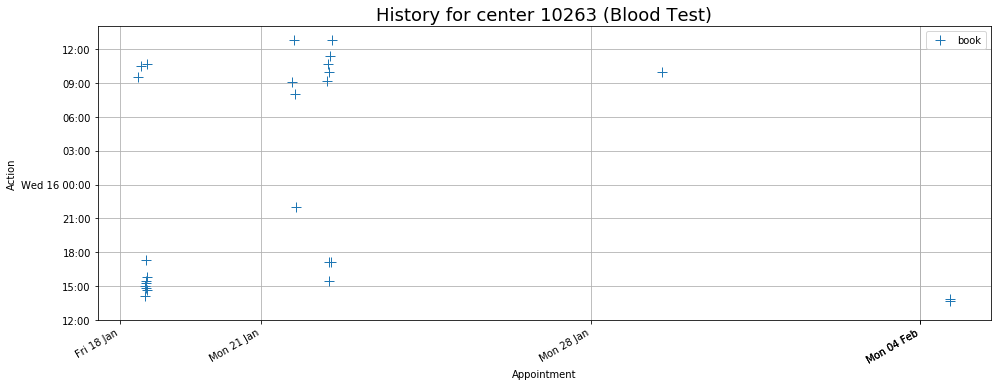

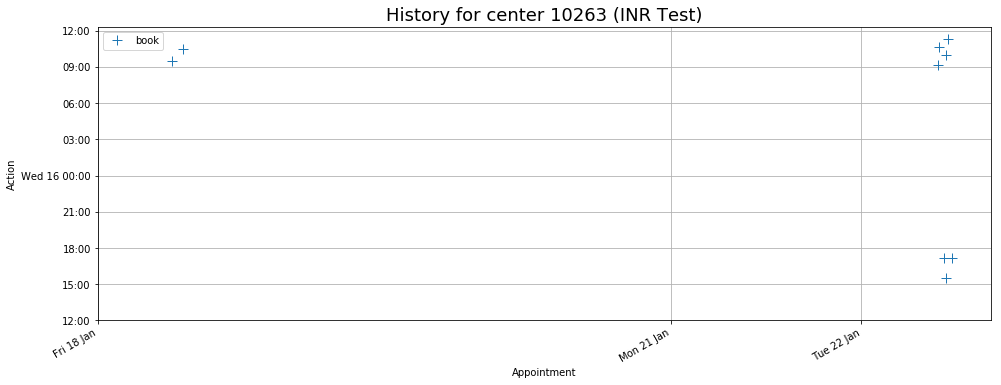

In [23]:
%%time
print(datetime.datetime.now().strftime("%H:%M:%S"))
for center_id in selected_centers[1:2]:
    #break
    print("Center: {0}".format(center_id))
    for test_type in list(center_test_types.loc[center_id])[0]:
        print("Test type: {0}".format(test_type))
        df_filtered = filter_center(df_history, center_id, test_type)
        df_filtered.iloc[0]#['id']
        UHCW_plot(
            df_filtered.loc[:, ['id', 'test type', 'appointment', 'grab', 'action']],
            x_freq="W",
            y_freq="H",
            savefigure=False
        );

Record time of end of script:

In [24]:
end_script = datetime.datetime.now()

In [25]:
run_time = end_script - beg_script

In [26]:
print("{0}min {1}sec".format(run_time.seconds//60, run_time.seconds%60))

5min 52sec
